# Quantifying Classification Uncertainty in Deep Neural Networks

The purpose of this page is to provide an easy-to-run demo with low computational requirements for the ideas proposed in the paper _Evidential Deep Learning to Quantify Classification Uncertainty_. Using MNIST dataset, I demonstrate how to create neural networks that are able to quantify classification uncertainty. The paper can be accesed over http://arxiv.org/abs/1806.01768

You can run this notebook in Colab using the colab icon below:


<a href="https://colab.research.google.com/github/muratsensoy/muratsensoy.github.io/blob/master/uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook can also be downloaded using https://muratsensoy.github.io/uncertainty.ipynb

#  Neural Networks Trained with Softmax Cross Entropy Loss

The following lines of codes demonstrate how softmax based Deep Neural Networks fail when they encounter out-of-sample queries.

In [2]:
# import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd

%matplotlib inline
import pylab as pl
from IPython import display

from sl import MultinomialOpinion
import os

# try:
#     tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")
# except Exception:
#     tf.keras.mixed_precision.set_global_policy("float32")

# tf.config.threading.set_intra_op_parallelism_threads(0)  # let TF decide
# tf.config.threading.set_inter_op_parallelism_threads(0)

In [3]:
# import importlib
# import sl
# importlib.reload(sl)   
# from sl import MultinomialOpinion

In [4]:
n_epoch = 100

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Choose 5 classes (0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer)
classes_to_keep = [0, 1, 2, 3, 4]

# Filter training data
train_mask = np.isin(y_train, classes_to_keep).flatten()
x_train, y_train = x_train[train_mask], y_train[train_mask]

# Filter test data
test_mask = np.isin(y_test, classes_to_keep).flatten()
x_test, y_test = x_test[test_mask], y_test[test_mask]

# Preprocess
x_train = x_train.reshape(-1, 3072).astype("float32") / 255.0
x_test = x_test.reshape(-1, 3072).astype("float32") / 255.0

# One-hot labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

K = 10  # number of classes

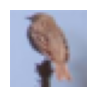

In [6]:
digit_one = x_train[100].reshape(32, 32, 3)  # shape (32, 32, 3)
plt.figure(figsize=(1, 1)) 
plt.imshow(digit_one)           # RGB image
plt.axis("off")
plt.show()

In [7]:
y_test[3]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [8]:
# define some utility functions
def rotate_img(x, deg):
    import scipy.ndimage as nd
    import numpy as np
    
    # CIFAR-10 images are 32x32x3
    if x.shape == (3072,):  # if it's flattened
        x = x.reshape(32, 32, 3)

    # Rotate each channel separately
    rotated = np.zeros_like(x)
    for c in range(3):
        rotated[:, :, c] = nd.rotate(x[:, :, c], deg, reshape=False)

    return rotated  # shape (32, 32, 3)


## LeNet

In [9]:
def LeNet_softmax(lmb=0.005):
    import tensorflow as tf
    l2 = tf.keras.regularizers.l2(lmb)

    model = tf.keras.Sequential([
        # CIFAR-10 input: 32x32 RGB (3 channels)
        tf.keras.layers.Reshape((32, 32, 3), input_shape=(32*32*3,)),

        tf.keras.layers.Conv2D(192, kernel_size=5, activation='relu', kernel_regularizer=l2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(192, kernel_size=5, activation='relu', kernel_regularizer=l2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(1000, activation='relu', kernel_regularizer=l2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=l2)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [10]:
# 3. Build the model
model_LeNet = LeNet_softmax()

# 4. Train the model
history = model_LeNet.fit(
    x_train, y_train,
    batch_size=1000,        # same as your old bsize
    epochs=n_epoch,              # same number of epochs
    validation_data=(x_test, y_test),
    verbose=2               # shows progress like before
)

# 5. Final evaluation
train_loss, train_acc = model_LeNet.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model_LeNet.evaluate(x_test, y_test, verbose=0)
print(f"Final training accuracy: {train_acc:.4f} \t testing accuracy: {test_acc:.4f}")

c:\ProgramData\miniconda3\envs\snn\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


KeyboardInterrupt: 

The test accuracy after 50 epochs is around 98.9%. Now, we want to classify a rotating digit from MNIST dataset to see how this network does for the samples that are not from the training set distribution. The following lines of codes helps us to see it.

In [ ]:
def rotating_image_classification(img, model, uncertainty_fn=None, threshold=0.5, K=10, is_edl=False, is_snn=False):
    """
    Rotate a CIFAR-10 image counter-clockwise and classify it for different degrees of rotation.
    Works with both softmax models and EDL models.

    Args:
        img : np.array, shape (32,32,3) or (3072,)
            Input CIFAR-10 image (values in [0,1]).
        model : tf.keras.Model
            Trained model (softmax, EDL, or SNN).
        uncertainty_fn : callable or None
            Function (model, image_batch) -> uncertainty values. Optional.
        threshold : float
            Probability threshold for keeping class predictions.
        K : int
            Number of classes (default = 10 for CIFAR-10).
        is_edl : bool
            If True, treat model outputs as EDL logits -> convert to Dirichlet probs.
        is_snn : bool
            If True, treat model as spiking NN with thresholding.
    """
    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt

    Mdeg = 180
    Ndeg = int(Mdeg / 10) + 1
    ldeg, lp, lu = [], [], []
    scores = np.zeros((1, K))
    rimgs = np.zeros((32, 32 * Ndeg, 3))

    for i, deg in enumerate(np.linspace(0, Mdeg, Ndeg)):
        # --- rotate each channel ---
        if img.ndim == 1:  # flattened
            nimg = img.reshape(32, 32, 3)
        else:
            nimg = img.copy()

        rotated = np.zeros_like(nimg)
        for c in range(3):
            rotated[:, :, c] = nd.rotate(nimg[:, :, c], deg, reshape=False)

        rotated = np.clip(rotated, 0, 1)
        rimgs[:, i*32:(i+1)*32, :] = rotated

        # prepare for model input
        if len(model.input_shape) == 2:  # flattened input
            nimg_input = rotated.reshape(1, -1)
        else:  # image input
            nimg_input = rotated[np.newaxis, ...]

        logits = model.predict(nimg_input, verbose=0)

        # --- Handle EDL vs Softmax ---
        if is_edl:
            evidence = np.maximum(logits, 0)
            alpha = evidence + 1
            p_pred_t = alpha / np.sum(alpha, axis=1, keepdims=True)
            u = K / np.sum(alpha, axis=1, keepdims=True)
        elif is_snn:
            p_pred_t = tf.nn.softmax(logits, axis=-1)
        else:
            p_pred_t = logits  # already probs

        # Uncertainty if provided
        if uncertainty_fn is not None:
            u = uncertainty_fn(model, nimg_input)
            lu.append(u.mean())

        if is_snn:
            scores += tf.cast(p_pred_t >= threshold, tf.int32).numpy()
        else:
            scores += (p_pred_t >= threshold)

        ldeg.append(deg)
        lp.append(p_pred_t[0])

    # keep only active labels
    labels = np.arange(K)[scores[0].astype(bool)]
    lp = np.array(lp)[:, labels]

    # --- plot probabilities ---
    c = ['black','blue','red','brown','purple','cyan','green','orange','pink','gray']
    marker = ['s','^','o','x','d'] * 2
    labels = labels.tolist()

    for i in range(len(labels)):
        plt.plot(ldeg, lp[:, i], marker=marker[i], c=c[i])

    if uncertainty_fn is not None:
        labels += ['uncertainty']
        plt.plot(ldeg, lu, marker='<', c='red')

    plt.legend(labels)
    plt.xlim([0, Mdeg])
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    # --- montage of rotated images ---
    plt.figure(figsize=(12, 4))
    plt.imshow(rimgs)
    plt.axis('off')
    plt.show()


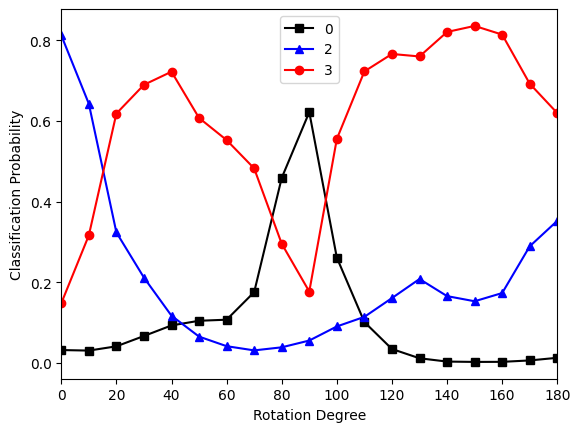

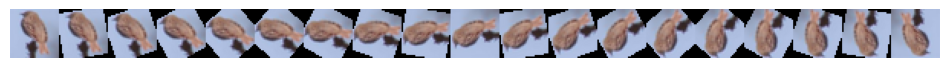

In [ ]:
rotating_image_classification(digit_one, model_LeNet)

As shown above, a neural network trained to generate softmax probabilities fails significantly when it encounters a sample that is different from the training examples. The softmax forces neural network to pick one class, even though the object belongs to an unknown category. This is demonstrated when we rotate the digit one between 60 and 130 degrees.

# Classification with Evidential Deep Learning

In the following sections, we train the same neural network using the loss functions introduced in the paper.

## Using the Expected Mean Square Error (Eq. 5)

As described in the paper, a neural network can be trained to learn parameters of a Dirichlet distribution, instead of softmax probabilities. Dirichlet distributions with parameters $\alpha \geq 1$ behaves like a generative model for softmax probabilities (categorical distributions). It associates a likelihood value with each categorical distribution.

## Some functions to convert logits to evidence

In [ ]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits):
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

# This one is another alternative and
# usually behaves better than the relu_evidence
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

## Define the loss function

In [ ]:
def KL(alpha):
    beta = tf.ones((1, K), dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
    S_beta = tf.reduce_sum(beta, axis=1, keepdims=True)
    lnB = tf.math.lgamma(S_alpha) - tf.reduce_sum(tf.math.lgamma(alpha), axis=1, keepdims=True)
    lnB_uni = tf.reduce_sum(tf.math.lgamma(beta), axis=1, keepdims=True) - tf.math.lgamma(S_beta)
    dg0 = tf.math.digamma(S_alpha)
    dg1 = tf.math.digamma(alpha)
    return tf.reduce_sum((alpha - beta) * (dg1 - dg0), axis=1, keepdims=True) + lnB + lnB_uni

# ---- Custom EDL Loss ----
def edl_mse_loss(p, alpha, global_step, annealing_step):
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    E = alpha - 1
    m = alpha / S

    A = tf.reduce_sum((p - m) ** 2, axis=1, keepdims=True)
    B = tf.reduce_sum(alpha * (S - alpha) / (S*S*(S+1)), axis=1, keepdims=True)

    annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32))

    alp = E * (1 - p) + 1
    C = annealing_coef * KL(alp)
    return (A + B) + C


In [ ]:
# ---- Custom EDL Loss ----
def edl_mse_loss(p, alpha, global_step, annealing_step):
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    E = alpha - 1
    m = alpha / S

    A = tf.reduce_sum((p - m) ** 2, axis=1, keepdims=True)
    B = tf.reduce_sum(alpha * (S - alpha) / (S*S*(S+1)), axis=1, keepdims=True)

    annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step, tf.float32))

    alp = E * (1 - p) + 1
    C = annealing_coef * KL(alp)
    return (A + B) + C

class EDLLoss(tf.keras.losses.Loss):
    def __init__(self, annealing_step, **kwargs):
        super().__init__(**kwargs)
        self.global_step = tf.Variable(0, trainable=False, dtype=tf.float32)
        self.annealing_step = annealing_step

    def call(self, y_true, y_pred):
        evidence = relu_evidence(y_pred)  # you can swap with exp_evidence or softplus_evidence
        alpha = evidence + 1
        loss = edl_mse_loss(y_true, alpha, self.global_step, self.annealing_step)
        self.global_step.assign_add(1.0)
        return tf.reduce_mean(loss)
    
    def uncertainty(self, y_pred):
        evidence = relu_evidence(y_pred)
        alpha = evidence + 1
        K = tf.cast(tf.shape(y_pred)[-1], tf.float32)
        return K / tf.reduce_sum(alpha, axis=1, keepdims=True)

# ---- LeNet EDL Model ----
def LeNet_EDL(lmb=0.005):
    l2 = tf.keras.regularizers.l2(lmb)
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((32, 32, 3), input_shape=(32*32*3,)),

        tf.keras.layers.Conv2D(192, kernel_size=5, activation='relu', kernel_regularizer=l2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(192, kernel_size=5, activation='relu', kernel_regularizer=l2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(1000, activation='relu', kernel_regularizer=l2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(K)  # raw logits
    ])
    return model

In [ ]:
class EDLLogger(tf.keras.callbacks.Callback):
    def __init__(self, x_train, y_train, x_test, y_test):
        super().__init__()
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.train_acc1, self.train_ev_s, self.train_ev_f = [], [], []
        self.test_acc1, self.test_ev_s, self.test_ev_f = [], [], []

    def on_epoch_end(self, epoch, logs=None):
        # Get predictions
        train_logits = self.model.predict(self.x_train, verbose=0)
        test_logits  = self.model.predict(self.x_test, verbose=0)

        # Convert logits -> evidence -> alpha
        evidence_train = relu_evidence(train_logits)
        alpha_train = evidence_train + 1
        pred_train = np.argmax(alpha_train, axis=1)
        truth_train = np.argmax(self.y_train, axis=1)
        correct_train = (pred_train == truth_train)

        evidence_test = relu_evidence(test_logits)
        alpha_test = evidence_test + 1
        pred_test = np.argmax(alpha_test, axis=1)
        truth_test = np.argmax(self.y_test, axis=1)
        correct_test = (pred_test == truth_test)

        # Mean evidence for success/failure
        total_ev_train = np.sum(evidence_train, axis=1)
        self.train_ev_s.append(np.mean(total_ev_train[correct_train]))
        self.train_ev_f.append(np.mean(total_ev_train[~correct_train]))
        self.train_acc1.append(np.mean(correct_train))

        total_ev_test = np.sum(evidence_test, axis=1)
        self.test_ev_s.append(np.mean(total_ev_test[correct_test]))
        self.test_ev_f.append(np.mean(total_ev_test[~correct_test]))
        self.test_acc1.append(np.mean(correct_test))


In [ ]:
model_EDL = LeNet_EDL()

# Compile with custom EDL loss
loss_fn = EDLLoss(annealing_step=10*(len(x_train)//1000))
model_EDL.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_fn, metrics=['accuracy'])

# Train
logger = EDLLogger(x_train, y_train, x_test, y_test)
history = model_EDL.fit(
    x_train, y_train,
    batch_size=1000,
    epochs=n_epoch,
    validation_data=(x_test, y_test),
    callbacks=[logger],
    verbose=2
)

# Evaluate
print("Final test accuracy:", model_EDL.evaluate(x_test, y_test, verbose=0))

Epoch 1/50


25/25 - 171s - 7s/step - accuracy: 0.2611 - loss: 4.2913 - val_accuracy: 0.3316 - val_loss: 1.2995
Epoch 2/50
25/25 - 162s - 6s/step - accuracy: 0.3955 - loss: 1.0689 - val_accuracy: 0.4366 - val_loss: 0.9995
Epoch 3/50
25/25 - 184s - 7s/step - accuracy: 0.4519 - loss: 0.9829 - val_accuracy: 0.4772 - val_loss: 0.9690
Epoch 4/50
25/25 - 191s - 8s/step - accuracy: 0.4852 - loss: 0.9723 - val_accuracy: 0.5178 - val_loss: 0.9679
Epoch 5/50
25/25 - 189s - 8s/step - accuracy: 0.5126 - loss: 0.9706 - val_accuracy: 0.5536 - val_loss: 0.9674
Epoch 6/50
25/25 - 187s - 7s/step - accuracy: 0.3150 - loss: 0.9916 - val_accuracy: 0.2824 - val_loss: 0.9917
Epoch 7/50
25/25 - 178s - 7s/step - accuracy: 0.2918 - loss: 0.9876 - val_accuracy: 0.4198 - val_loss: 0.9830
Epoch 8/50
25/25 - 187s - 7s/step - accuracy: 0.4290 - loss: 0.9829 - val_accuracy: 0.4606 - val_loss: 0.9815
Epoch 9/50
25/25 - 181s - 7s/step - accuracy: 0.4748 - loss: 0.9814 - val_accuracy: 0.5038 - val_loss: 0.9795
Epoch 10/50
25/25 - 1

In [ ]:
def draw_EDL_results(train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f, K=10):
    # calculate uncertainty
    train_u_succ = K / (K + np.array(train_ev_s))
    train_u_fail = K / (K + np.array(train_ev_f))
    test_u_succ  = K / (K + np.array(test_ev_s))
    test_u_fail  = K / (K + np.array(test_ev_f))

    fig, axs = plt.subplots(2, 2, figsize=(10,10))

    # Train evidence
    axs[0,0].plot(train_ev_s, c='r', marker='+')
    axs[0,0].plot(train_ev_f, c='k', marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence')
    axs[0,0].legend(['Correct', 'Misclassified'])

    # Train uncertainty
    axs[0,1].plot(train_u_succ, c='r', marker='+')
    axs[0,1].plot(train_u_fail, c='k', marker='x')
    axs[0,1].plot(train_acc1, c='blue', marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Uncertainty')
    axs[0,1].legend(['Correct', 'Misclassified', 'Accuracy'])

    # Test evidence
    axs[1,0].plot(test_ev_s, c='r', marker='+')
    axs[1,0].plot(test_ev_f, c='k', marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence')
    axs[1,0].legend(['Correct', 'Misclassified'])

    # Test uncertainty
    axs[1,1].plot(test_u_succ, c='r', marker='+')
    axs[1,1].plot(test_u_fail, c='k', marker='x')
    axs[1,1].plot(test_acc1, c='blue', marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Uncertainty')
    axs[1,1].legend(['Correct', 'Misclassified', 'Accuracy'])

    plt.show()


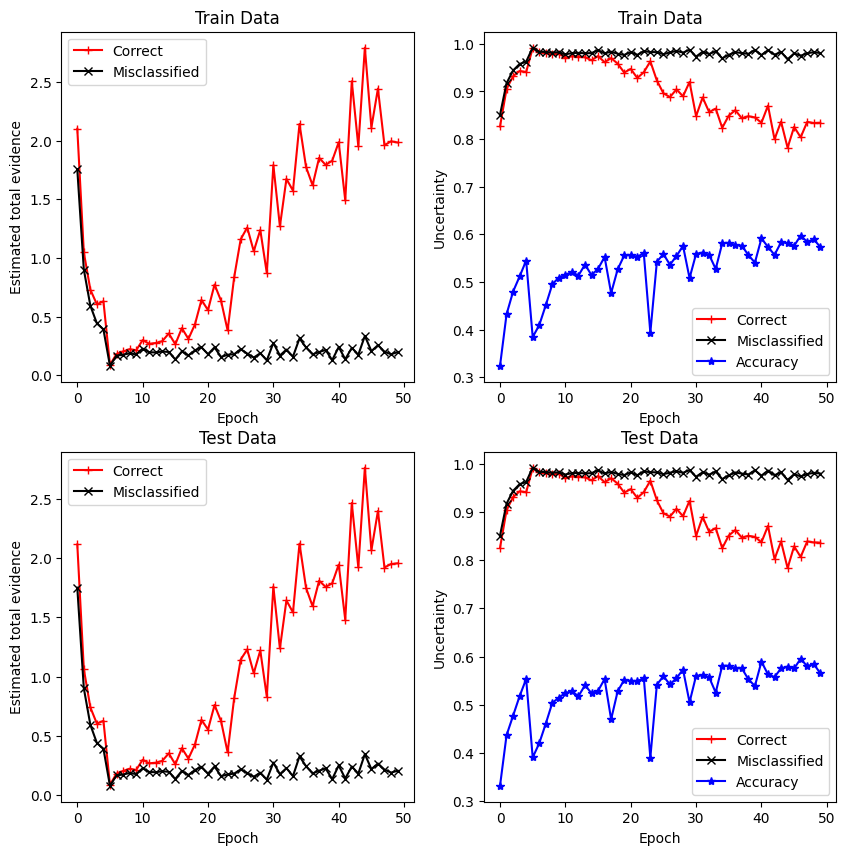

In [ ]:
draw_EDL_results(
    logger.train_acc1,
    logger.train_ev_s,
    logger.train_ev_f,
    logger.test_acc1,
    logger.test_ev_s,
    logger.test_ev_f,
    K=10
)

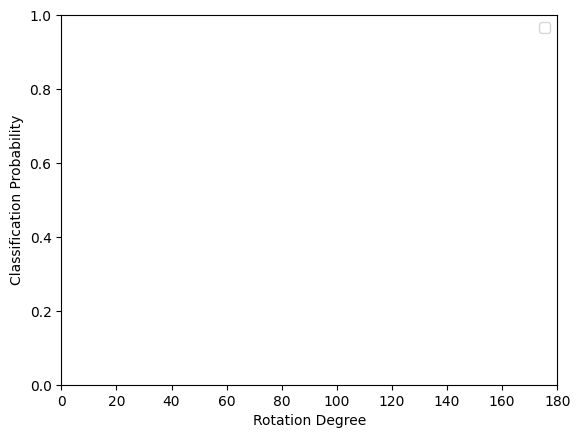

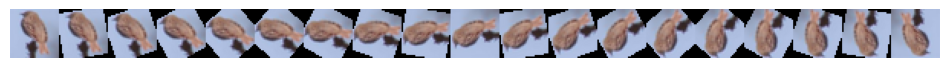

In [ ]:
rotating_image_classification(digit_one, model_EDL, is_edl=True)

The following function plots average total evidence and prediction uncertainty in addition to accuracy for the training and test sets. Let us note that uncertainty approaches to 1.0 as the total evidence approaches to 0.

The figure above indicates that the proposed approach generates much smaller amount of evidence for the misclassified samples than the correctly classified ones. The uncertainty of the misclassified samples are around 0.8, while it is around 0.1 for the correctly classified ones, both for training and testing sets. This means that the neural network is very uncertain for the misclassified samples and provides certain predictions only for the correctly classified ones. In other words, the neural network also predicts when it fails by assigning high uncertainty to its wrong predictions.

# SNN

In [ ]:

from tensorflow.keras import layers

K = 10  # number of classes

# -------------------------------
# Custom Bayesian Dense Layer
# -------------------------------
class BayesianDense(layers.Layer):
    def __init__(self, units, temperature=0.05, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.temperature = temperature

    def sample_p(self):
        """Sample p ~ Kumaraswamy(softplus(alpha), softplus(beta))"""
        alpha_sp = tf.nn.softplus(self.alpha)
        beta_sp = tf.nn.softplus(self.beta)
        u = tf.random.uniform(tf.shape(alpha_sp), 1e-7, 1-1e-7)
        return 1.0 - (1.0 - u ** (1.0 / beta_sp)) ** (1.0 / alpha_sp)

    def apply_mask(self, inputs, p, temperature=0.05):
        """Apply mask sampled from Concrete(p) to W"""
        u2 = tf.random.uniform(tf.shape(p), 1e-7, 1-1e-7)
        gumbel = -tf.math.log(-tf.math.log(u2))
        logit = tf.math.log(p + 1e-7) - tf.math.log(1.0 - p + 1e-7)
        mask = tf.nn.sigmoid((logit + gumbel) / temperature)
        W_eff = self.W_val * mask
        return tf.matmul(inputs, W_eff) + self.b
    
    def build(self, input_shape):
        in_dim = input_shape[-1]
        self.W_val = self.add_weight(shape=(in_dim, self.units),
                                     initializer="random_normal",
                                     trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros",
                                 trainable=True)
        self.alpha = self.add_weight(shape=(in_dim, self.units),
                                     initializer=tf.keras.initializers.Constant(-1.0),
                                     trainable=True)
        self.beta = self.add_weight(shape=(in_dim, self.units),
                                    initializer=tf.keras.initializers.Constant(-1.0),
                                    trainable=True)

    def call(self, inputs, training=None):
        # Kumaraswamy sampling
        u = tf.random.uniform(tf.shape(self.alpha), minval=1e-7, maxval=1-1e-7)
        p = 1.0 - (1.0 - u**(1.0/tf.nn.softplus(self.beta)))**(1.0/tf.nn.softplus(self.alpha))

        # Concrete mask
        u2 = tf.random.uniform(tf.shape(p), minval=1e-7, maxval=1-1e-7)
        gumbel = -tf.math.log(-tf.math.log(u2))
        logit = tf.math.log(p + 1e-7) - tf.math.log(1.0 - p + 1e-7)
        mask = tf.nn.sigmoid((logit + gumbel) / self.temperature)

        W_eff = self.W_val * mask
        return tf.matmul(inputs, W_eff) + self.b

class BayesianConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1,1), padding="same", temperature=0.05, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.strides = strides
        self.padding = padding.upper()
        self.temperature = temperature

    def sample_p(self):
        alpha_sp = tf.nn.softplus(self.alpha)
        beta_sp = tf.nn.softplus(self.beta)
        u = tf.random.uniform(tf.shape(alpha_sp), 1e-7, 1-1e-7)
        return 1.0 - (1.0 - u ** (1.0 / beta_sp)) ** (1.0 / alpha_sp)

    def apply_mask(self, inputs, p, temperature=0.05):
        u2 = tf.random.uniform(tf.shape(p), 1e-7, 1-1e-7)
        gumbel = -tf.math.log(-tf.math.log(u2))
        logit = tf.math.log(p + 1e-7) - tf.math.log(1.0 - p + 1e-7)
        mask = tf.nn.sigmoid((logit + gumbel) / temperature)
        W_eff = self.W_val * mask
        out = tf.nn.conv2d(inputs, W_eff, strides=[1, *self.strides, 1], padding=self.padding)
        return tf.nn.bias_add(out, self.b)
    
    def build(self, input_shape):
        in_channels = input_shape[-1]

        # Convolutional kernel parameters
        self.W_val = self.add_weight(
            shape=(*self.kernel_size, in_channels, self.filters),
            initializer="random_normal",
            trainable=True,
            name="W_val"
        )
        self.b = self.add_weight(
            shape=(self.filters,),
            initializer="zeros",
            trainable=True,
            name="b"
        )

        # Variational parameters for Bayesian masking
        self.alpha = self.add_weight(
            shape=(*self.kernel_size, in_channels, self.filters),
            initializer=tf.keras.initializers.Constant(-1.0),
            trainable=True,
            name="alpha"
        )
        self.beta = self.add_weight(
            shape=(*self.kernel_size, in_channels, self.filters),
            initializer=tf.keras.initializers.Constant(-1.0),
            trainable=True,
            name="beta"
        )

    def call(self, inputs, training=None):
        # Kumaraswamy sample
        u = tf.random.uniform(tf.shape(self.alpha), minval=1e-7, maxval=1-1e-7)
        p = 1.0 - (1.0 - u**(1.0/tf.nn.softplus(self.beta)))**(1.0/tf.nn.softplus(self.alpha))

        # Concrete mask
        u2 = tf.random.uniform(tf.shape(p), minval=1e-7, maxval=1-1e-7)
        gumbel = -tf.math.log(-tf.math.log(u2))
        logit = tf.math.log(p + 1e-7) - tf.math.log(1.0 - p + 1e-7)
        mask = tf.nn.sigmoid((logit + gumbel) / self.temperature)

        # Effective kernel
        W_eff = self.W_val * mask

        # Convolution operation
        out = tf.nn.conv2d(inputs, W_eff, strides=[1, *self.strides, 1], padding=self.padding)
        out = tf.nn.bias_add(out, self.b)
        return out

# -------------------------------
# KL divergence for Beta prior
# -------------------------------
def kl_beta(alpha_q, beta_q, alpha_p=1.0, beta_p=1.0):
    term1 = tf.math.lgamma(alpha_p) + tf.math.lgamma(beta_p) - tf.math.lgamma(alpha_p+beta_p)
    term1 -= (tf.math.lgamma(alpha_q) + tf.math.lgamma(beta_q) - tf.math.lgamma(alpha_q+beta_q))
    term2 = (alpha_q - alpha_p) * tf.math.digamma(alpha_q)
    term3 = (beta_q - beta_p) * tf.math.digamma(beta_q)
    term4 = (alpha_p + beta_p - alpha_q - beta_q) * tf.math.digamma(alpha_q+beta_q)
    return term1 + term2 + term3 + term4

# -------------------------------
# Bayesian LeNet in Keras
# -------------------------------
def BayesianLeNet(num_classes=10):
    inputs = tf.keras.Input(shape=(32*32*3,))
    x = layers.Reshape((32, 32, 3))(inputs)

    # Bayesian conv layers
    x = BayesianConv2D(192, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = BayesianConv2D(192, 5, padding="valid")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    # Flatten
    x = layers.Flatten()(x)

    # Bayesian dense layers
    x = BayesianDense(1000)(x)
    x = layers.Activation("relu")(x)

    outputs = BayesianDense(num_classes)(x)

    return tf.keras.Model(inputs, outputs)



# -------------------------------
# Custom loss: ELBO
# -------------------------------
class ELBOLoss(tf.keras.losses.Loss):
    def __init__(self, lmb=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.lmb = lmb

    def call(self, y_true, logits):
        ce = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
        likelihood = tf.reduce_mean(ce)
        kl = 0.0
        return likelihood + self.lmb * kl



In [ ]:
model_snn = BayesianLeNet()

# Compile with custom ELBO loss
model_snn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=ELBOLoss(),
    metrics=["accuracy"]
)

# Train
history = model_snn.fit(
    x_train, y_train,
    batch_size=1000,
    epochs=n_epoch,
    validation_data=(x_test, y_test),
    verbose=2
)

# Evaluate
train_loss, train_acc = model_snn.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model_snn.evaluate(x_test, y_test, verbose=0)
print(f"Final training accuracy: {train_acc:.4f} \t testing accuracy: {test_acc:.4f}")



Epoch 1/100
25/25 - 162s - 6s/step - accuracy: 0.2008 - loss: 1.8624 - val_accuracy: 0.2086 - val_loss: 1.6915
Epoch 2/100
25/25 - 155s - 6s/step - accuracy: 0.2327 - loss: 1.6722 - val_accuracy: 0.2426 - val_loss: 1.6450
Epoch 3/100
25/25 - 169s - 7s/step - accuracy: 0.2359 - loss: 1.6387 - val_accuracy: 0.2722 - val_loss: 1.6120
Epoch 4/100
25/25 - 163s - 7s/step - accuracy: 0.2778 - loss: 1.6127 - val_accuracy: 0.3484 - val_loss: 1.5188
Epoch 5/100
25/25 - 188s - 8s/step - accuracy: 0.2901 - loss: 1.5893 - val_accuracy: 0.3368 - val_loss: 1.5640
Epoch 6/100
25/25 - 206s - 8s/step - accuracy: 0.3203 - loss: 1.5218 - val_accuracy: 0.3052 - val_loss: 1.6014
Epoch 7/100
25/25 - 211s - 8s/step - accuracy: 0.3421 - loss: 1.5050 - val_accuracy: 0.3220 - val_loss: 1.5782
Epoch 8/100


AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/functional_1/bayesian_conv2d_1_2/Conv2DBackpropFilter defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node StatefulPartitionedCall/gradient_tape/functional_1/bayesian_conv2d_1_2/Conv2DBackpropFilter}}]] [Op:__inference_multi_step_on_iterator_4160]

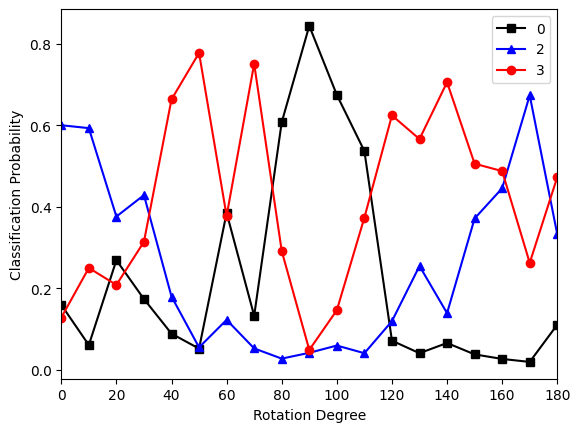

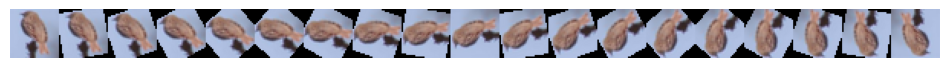

In [ ]:
rotating_image_classification(digit_one, model_snn, is_snn=True)

In [ ]:
def predict_nested_samples_with_raw(model, x, n_p=15, n_mask=15, temperature=0.05):
    """
    Nested sampling with fixed p but multiple mask resamples.
    """
    batch_size = int(tf.shape(x)[0])
    results = [[] for _ in range(batch_size)]

    for _ in range(n_p):
        # === Sample p once per layer ===
        p1 = model.layers[2].sample_p()   # first BayesianConv2D
        p2 = model.layers[5].sample_p()   # second BayesianConv2D
        p3 = model.layers[9].sample_p()   # first BayesianDense
        p4 = model.layers[11].sample_p()  # output BayesianDense

        preds_mask = []
        for _ in range(n_mask):
            # Forward pass with fixed p but new masks
            h1 = model.layers[2].apply_mask(tf.reshape(x, [-1, 32, 32, 3]), p=p1, temperature=temperature)
            h1 = tf.nn.relu(h1)
            h1 = tf.nn.max_pool2d(h1, ksize=2, strides=2, padding="VALID")

            h2 = model.layers[5].apply_mask(h1, p=p2, temperature=temperature)
            h2 = tf.nn.relu(h2)
            h2 = tf.nn.max_pool2d(h2, ksize=2, strides=2, padding="VALID")

            h2_flat = tf.reshape(h2, [tf.shape(h2)[0], -1])
            h3 = model.layers[9].apply_mask(h2_flat, p=p3, temperature=temperature)
            h3 = tf.nn.relu(h3)

            logits = model.layers[11].apply_mask(h3, p=p4, temperature=temperature)
            probs = tf.nn.softmax(logits, axis=-1)

            preds_mask.append(probs)

        preds_mask = tf.stack(preds_mask, axis=0)   # [n_mask, batch, num_classes]
        avg_pred = tf.reduce_mean(preds_mask, axis=0)

        for i in range(batch_size):
            results[i].append((avg_pred[i], preds_mask[:, i]))

    # format like PyTorch version
    final_output = []
    for sample_results in results:
        avg_list, raw_list = zip(*sample_results)
        avg_tensor = tf.stack(avg_list, axis=0)   # [n_p, num_classes]
        raw_tensor = tf.reshape(tf.stack(raw_list, axis=0), [n_p * n_mask, -1])
        final_output.append((avg_tensor, raw_tensor))

    return final_output

def predict_nested_samples_op(model, x, n_p=10, n_mask=10, temperature=0.05):
    pred = predict_nested_samples_with_raw(model, x)
    res = []
    for i in range(len(pred)):
        res.append(MultinomialOpinion.from_list_prob(pred[i]))
    return pred 


In [ ]:
def load_notmnist(batch_size=128):
    data_dir = "./data/notMNIST"  # should contain subfolders A-J

    if not os.path.exists(data_dir):
        raise RuntimeError("Download notMNIST_small manually and unzip it under ./data/notMNIST")

    # Load dataset from directory (expects subfolders as class labels)
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",  # integers 0–9 for A–J
        color_mode="grayscale",
        batch_size=batch_size,
        image_size=(32, 32, 3),   # resize automatically
        shuffle=False
    )
    
    # Normalize + flatten
    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [-1, 32*32*3])  # flatten to 784
        return image, label

    ds = ds.map(preprocess)

    # Collect all data into memory
    X = []
    y = []
    for images, labels in ds:
        X.append(images)
        y.append(labels)

    X = tf.concat(X, axis=0)
    y = tf.concat(y, axis=0)

    return X, y


In [ ]:
results_g = predict_nested_samples_with_raw(model_snn, x_test)

In [ ]:
# import os
# from PIL import Image

# def clean_notmnist(data_dir="./data/notMNIST"):
#     bad_files = []
#     for root, _, files in os.walk(data_dir):
#         for f in files:
#             path = os.path.join(root, f)
#             try:
#                 with Image.open(path) as img:
#                     img.verify()
#             except Exception:
#                 bad_files.append(path)

#     print("Removing bad files:", len(bad_files))
#     for f in bad_files:
#         os.remove(f)

# clean_notmnist()

In [ ]:
# x_not_mnist, y_not_mnist = load_notmnist()
# results_n = predict_nested_samples_with_raw(model_snn, x_not_mnist)

In [ ]:
# print("x_train:", x_train.shape, x_train.dtype, type(x_train))
# print("x_not_mnist:", x_not_mnist.shape, x_not_mnist.dtype, type(x_not_mnist))

# print("First x_train element range:", x_train.numpy().min(), x_train.numpy().max())
# print("First x_not_mnist element range:", x_not_mnist.numpy().min(), x_not_mnist.numpy().max())

In [ ]:
# print(MultinomialOpinion.from_list_prob(results_n[1][0]).u)

In [ ]:
# print(MultinomialOpinion.from_list_prob(results_n[1][0].numpy().T))

In [ ]:
# print(MultinomialOpinion.from_list_prob(results_n[2][0]).u)

In [ ]:
def show_im(x, y):
    try:
        img = x.numpy().reshape(32, 32, 3)
    except:
        img = x.reshape(32, 32, 3)

    plt.figure(figsize=(1, 1)) 
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {y}")
    plt.axis("off")
    plt.show()
# show_im(x_not_mnist[1], 0)

In [ ]:
pred = results_g
res_g = []
for i in range(len(pred)):
    res_g.append(MultinomialOpinion.from_list_prob(pred[i][0]).get_best_belief_uncertainty())
res_g = np.array(res_g)

In [ ]:
np.median(res_g[:,2]), np.mean(res_g[:,2])

(np.float64(0.17766901470739738), np.float64(0.18981699688697182))

In [ ]:
a1, a2 = np.argmax(res_g[:,2]), np.argmin(res_g[:,2])

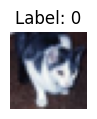

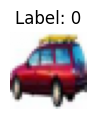

In [ ]:
show_im(x_test[a1], 0)
show_im(x_test[a2], 0)

In [ ]:
import pickle

def save_data(data, fname):
    with open(fname, "wb") as f:
        pickle.dump(data, f)

def load_data(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

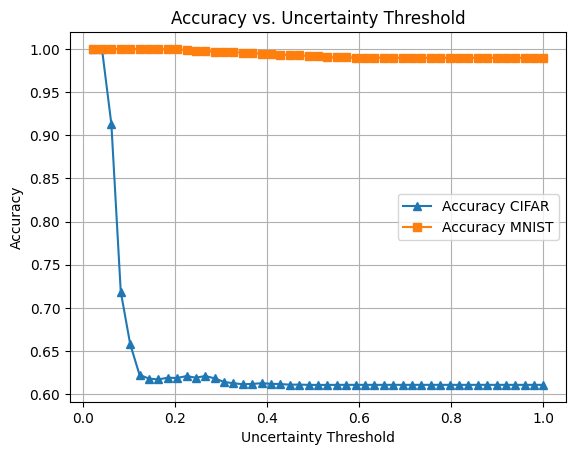

In [ ]:
def accuracy_vs_threshold(y_true, y_pred, uncertainty, thresholds=50):
    """
    y_true: array of shape (N,) with ground-truth labels
    y_pred: array of shape (N,) with predicted labels (NOT probabilities)
    uncertainty: array of shape (N,) with uncertainty values
    thresholds: number of thresholds or list of thresholds
    """
    if y_pred.ndim > 1:  # if still probabilities
        y_pred = np.argmax(y_pred, axis=1)

    thresholds = np.linspace(0, 1, thresholds) if isinstance(thresholds, int) else np.array(thresholds)
    accs, coverages = [], []

    for t in thresholds:
        mask = uncertainty <= t
        if mask.sum() == 0:
            accs.append(np.nan)
            coverages.append(0)
        else:
            accs.append((y_pred[mask] == y_true[mask]).mean())
            coverages.append(mask.mean())

    return thresholds, np.array(accs), np.array(coverages)


# Run
ytrue = np.argmax(y_test, axis=1)
thresholds, accs, coverages = accuracy_vs_threshold(ytrue, res_g[:,0], res_g[:,2])

thresholds_mnist, accs_mnist, coverages_mnist = load_data("MNIST_res/thres.pkl"), load_data("MNIST_res/accs.pkl"), load_data("MNIST_res/coverages.pkl")
# Plot accuracy vs. uncertainty threshold
plt.plot(thresholds, accs,  marker="^", label="Accuracy CIFAR")
plt.plot(thresholds_mnist, accs_mnist,  marker="s", label="Accuracy MNIST")
plt.xlabel("Uncertainty Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Uncertainty Threshold")
plt.grid()
plt.legend()
plt.show()

In [ ]:
save_data(thresholds, "thresholds.pkl")
save_data(accs, "accs.pkl")
save_data(coverages, "coverages.pkl")

In [ ]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

7.0
0.001996244199752895


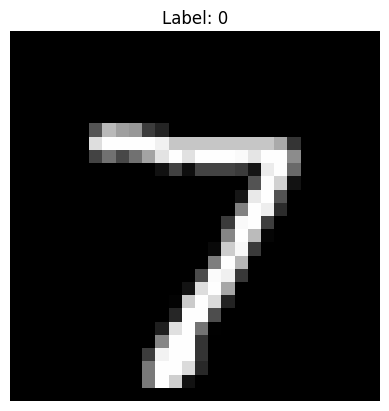

In [ ]:
ii = 0
print(res_g[ii][0])
print(res_g[ii][2])
show_im(x_test[ii],0)

In [ ]:
results_g[ii][0]

<tf.Tensor: shape=(15, 10), dtype=float32, numpy=
array([[6.29938990e-09, 1.62943238e-07, 7.42533928e-08, 1.19824533e-08,
        9.99553025e-01, 2.20403447e-08, 2.04755065e-06, 9.74644308e-07,
        3.13916146e-08, 4.43629571e-04],
       [3.99746281e-09, 3.83550608e-10, 8.95709107e-08, 6.36696740e-09,
        9.99994457e-01, 3.27227312e-08, 1.53131751e-07, 2.67183054e-06,
        1.74149459e-08, 2.59952844e-06],
       [1.58412234e-08, 5.02744903e-08, 1.37472611e-07, 1.86076921e-09,
        9.99936521e-01, 1.53714304e-08, 3.54516168e-08, 3.55911340e-07,
        8.94343160e-08, 6.27053450e-05],
       [1.26066340e-07, 9.33936448e-08, 2.55885595e-07, 2.13839826e-08,
        9.97417152e-01, 4.88024199e-08, 5.03488127e-06, 3.36248974e-07,
        9.54074864e-08, 2.57684803e-03],
       [6.25940100e-09, 5.55640938e-08, 7.28171585e-07, 3.52593044e-09,
        9.99896467e-01, 2.35185329e-08, 3.75589707e-06, 2.13689123e-06,
        3.62466409e-07, 9.63895218e-05],
       [2.28630412e-08, 3

In [ ]:
rr = predict_nested_samples_with_raw(model_snn, [x_test[ii]])
# predict_nested_samples_with_raw(model_snn, x_test)
# rr

In [ ]:
logits = model_snn(x_test, training=True)   # force sampling
probs = tf.nn.softmax(logits, axis=-1)
pred = tf.argmax(probs, axis=-1)


<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([7, 2, 1, ..., 4, 5, 6], shape=(10000,))>

In [ ]:
pred.numpy()[ii]

np.int64(4)

In [ ]:
y_test[ii]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
acc = tf.reduce_mean(tf.cast(pred == y_test, tf.float32))
print("Stochastic accuracy:", float(acc))

Stochastic accuracy: 0.0


In [ ]:
np.median(res_n[:][2]), np.median(res_g[:][2])

(np.float64(0.25390895046121786), np.float64(0.9911599126137662))

In [ ]:
np.max(res), np.min(res)

(np.float64(0.8006284645172492), np.float64(0.0007025958546544409))

In [ ]:
np.argmax(res), np.argmin(res)

(np.int64(14596), np.int64(13733))

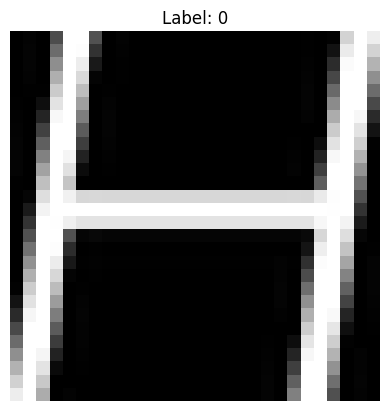

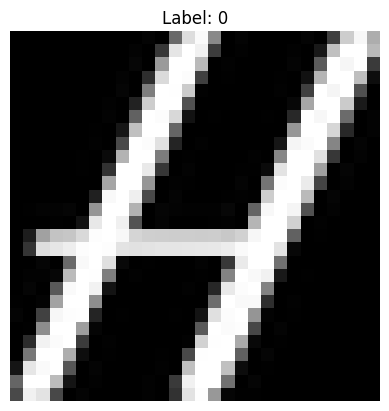

In [ ]:
show_im(x_not_mnist[14596], 0)
show_im(x_not_mnist[13733], 0)

In [ ]:
model_snn(x_not_mnist[14596])

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input [0.         0.01176471 0.         0.3019608  1.         1.
 0.31764707 0.         0.01176471 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00392157 0.
 0.00784314 0.83137256 1.         0.93333334 0.         0.01568628
 0.         0.42352942 1.         0.99215686 0.19607843 0.
 0.00784314 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00392157 0.         0.07058824 0.92156863
 1.         0.827451   0.         0.01568628 0.         0.5568628
 1.         0.92941177 0.09803922 0.         0.00392157 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00784314 0.         0.17254902 0.9843137  1.         0.7019608
 0.         0.01176471 0.         0.6862745  1.         0.8509804
 0.01568628 0.         0.00392157 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01176471 0.
 0.2784314  1.         1.         0.56078434 0.         0.00392157
 0.00392157 0.79607844 1.         0.7411765  0.         0.00392157
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01568628 0.         0.4117647  1.
 1.         0.42352942 0.00392157 0.         0.05490196 0.8901961
 1.         0.62352943 0.         0.01176471 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01568628 0.         0.54509807 1.         1.         0.2901961
 0.00784314 0.         0.14117648 0.972549   1.         0.49411765
 0.         0.01568628 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01176471 0.
 0.6745098  1.         0.96862745 0.16470589 0.01176471 0.
 0.25490198 1.         1.         0.35686275 0.         0.01568628
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.79607844 1.
 0.89411765 0.07450981 0.01568628 0.         0.37254903 1.
 1.         0.24313726 0.         0.01176471 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00392157
 0.         0.05098039 0.8862745  1.         0.8117647  0.00784314
 0.01568628 0.         0.5058824  1.         0.9607843  0.13333334
 0.         0.00784314 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00784314 0.         0.13333334
 0.972549   1.         0.69803923 0.         0.01568628 0.
 0.63529414 1.         0.88235295 0.04313726 0.         0.00392157
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.01176471 0.         0.24705882 1.         1.
 0.5764706  0.         0.00392157 0.         0.7490196  1.
 0.77254903 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.36862746 1.         1.         0.4509804  0.
 0.         0.01960784 0.87058824 1.         0.94509804 0.84313726
 0.84705883 0.84313726 0.84313726 0.84313726 0.84313726 0.84313726
 0.84313726 0.84313726 0.84313726 0.84313726 0.84313726 0.84313726
 0.84313726 0.84313726 0.84313726 0.84705883 0.84313726 0.91764706
 0.99215686 1.         0.31764707 0.         0.         0.10196079
 0.95686275 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99607843 1.
 0.2        0.         0.         0.2        1.         0.99607843
 0.9372549  0.8901961  0.89411765 0.8901961  0.8901961  0.8901961
 0.8901961  0.8901961  0.8901961  0.8901961  0.8901961  0.8901961
 0.8901961  0.8901961  0.8901961  0.8901961  0.89411765 0.8901961
 0.8901961  0.96862745 1.         0.95686275 0.10588235 0.
 0.         0.3137255  1.         1.         0.31764707 0.01960784
 0.03137255 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.03529412 0.84313726
 1.         0.87058824 0.02352941 0.         0.         0.44313726
 1.         0.99215686 0.1764706  0.         0.00392157 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.07843138 0.93333334 1.         0.7647059
 0.         0.00392157 0.         0.5686275  1.         0.9254902
 0.09411765 0.00392157 0.00784314 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.01176471 0.00392157
 0.1882353  0.9882353  1.         0.64705884 0.         0.01568628
 0.         0.6901961  1.         0.84313726 0.01568628 0.
 0.00392157 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01176471 0.         0.29803923 1.
 1.         0.5176471  0.         0.01568628 0.00784314 0.8039216
 1.         0.7372549  0.         0.00392157 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01568628 0.         0.43137255 1.         1.         0.38039216
 0.         0.01568628 0.07450981 0.8862745  1.         0.6117647
 0.         0.01176471 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01568628 0.
 0.5647059  1.         1.         0.2627451  0.         0.01176471
 0.16470589 0.9647059  1.         0.49019608 0.         0.01568628
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00784314 0.         0.6862745  1.
 0.9764706  0.14509805 0.         0.00784314 0.2901961  1.
 1.         0.35686275 0.         0.01176471 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.8039216  1.         0.9019608  0.05882353
 0.         0.00392157 0.41960785 1.         1.         0.23529412
 0.         0.01176471 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00392157 0.         0.05098039
 0.8980392  1.         0.80784315 0.00784314 0.         0.
 0.56078434 1.         0.9607843  0.13333334 0.         0.00784314
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00784314 0.         0.14509805 0.96862745 1.
 0.7019608  0.         0.01176471 0.         0.69803923 1.
 0.8901961  0.03921569 0.         0.00392157 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01176471
 0.         0.24705882 1.         1.         0.57254905 0.
 0.01176471 0.         0.81960785 1.         0.78431374 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01568628 0.         0.3764706
 1.         1.         0.43529412 0.         0.01568628 0.
 0.92941177 1.         0.6745098  0.         0.01176471 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.01568628 0.         0.5019608  1.         1.
 0.3137255  0.         0.01176471 0.        ]. Expected shape (None, 784), but input has incompatible shape (784,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(784,), dtype=float32)
  • training=None
  • mask=None
  • kwargs=<class 'inspect._empty'>

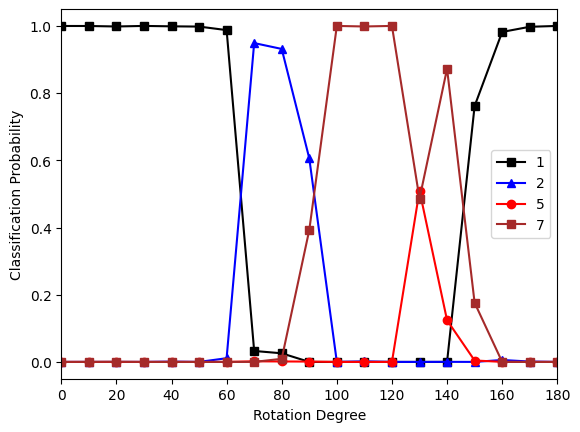

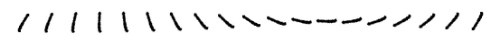

In [ ]:
rotating_image_classification(digit_one, model_snn, is_snn=True)

## Using the Expected Cross Entropy  (Eq. 4)

In this section, we train neural network using the loss function described in Eq. 4 in the paper. This loss function is derived using the expected value of the cross entropy loss over the predicted Dirichlet distribution.

In [ ]:
def loss_EDL(func=tf.digamma):
    def loss_func(p, alpha, global_step, annealing_step):
        S = tf.reduce_sum(alpha, axis=1, keep_dims=True)
        E = alpha - 1

        A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)

        annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))

        alp = E*(1-p) + 1
        B =  annealing_coef * KL(alp)

        return (A + B)
    return loss_func

AttributeError: module 'tensorflow' has no attribute 'digamma'

In [ ]:
g3, step3, X3, Y3, annealing_step3, keep_prob3, prob3, acc3, loss3, u3, evidence3, \
    mean_ev3, mean_ev_succ3, mean_ev_fail3 = LeNet_EDL(exp_evidence, loss_EDL(tf.digamma), lmb=0.001)

In [ ]:
sess3 = tf.Session(graph=g3)
with g3.as_default():
    sess3.run(tf.global_variables_initializer())

In [ ]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
L3_train_acc1=[]
L3_train_ev_s=[]
L3_train_ev_f=[]
L3_test_acc1=[]
L3_test_ev_s=[]
L3_test_ev_f=[]
for epoch in range(50):
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X3:data, Y3:label, keep_prob3:.5, annealing_step3:10*n_batches}
        sess3.run(step3,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')

    train_acc, train_succ, train_fail = sess3.run([acc3,mean_ev_succ3,mean_ev_fail3], feed_dict={X3:mnist.train.images,Y3:mnist.train.labels,keep_prob3:1.})
    test_acc, test_succ, test_fail = sess3.run([acc3,mean_ev_succ3,mean_ev_fail3], feed_dict={X3:mnist.test.images,Y3:mnist.test.labels,keep_prob3:1.})

    L3_train_acc1.append(train_acc)
    L3_train_ev_s.append(train_succ)
    L3_train_ev_f.append(train_fail)

    L3_test_acc1.append(test_acc)
    L3_test_ev_s.append(test_succ)
    L3_test_ev_f.append(test_fail)

    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' %
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

In [ ]:
draw_EDL_results(L3_train_acc1, L3_train_ev_s, L3_train_ev_f, L3_test_acc1, L3_test_ev_s, L3_test_ev_f)

The figure above indicates that the neural network generates much more evidence for the correctly classified samples. As a result, it has a very low uncertainty (around zero) for the correctly classified samples, while the uncertainty is very high (around 0.7) for the misclassified samples.

In [ ]:
rotating_image_classification(digit_one, sess3, prob3, X3, keep_prob3, u3)

In [ ]:
## Using Negative Log of the Expected Likelihood (Eq. 3)

In this section, we repeat our experiments using the loss function based on Eq. 3 in the paper.

In [ ]:
g4, step4, X4, Y4, annealing_step4, keep_prob4, prob4, acc4, loss4, u4, evidence4, \
    mean_ev4, mean_ev_succ4, mean_ev_fail4 = LeNet_EDL(exp_evidence, loss_EDL(tf.log), lmb=0.001)

In [ ]:
sess4 = tf.Session(graph=g4)
with g4.as_default():
    sess4.run(tf.global_variables_initializer())

In [ ]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
L4_train_acc1=[]
L4_train_ev_s=[]
L4_train_ev_f=[]
L4_test_acc1=[]
L4_test_ev_s=[]
L4_test_ev_f=[]
for epoch in range(50):
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X4:data, Y4:label, keep_prob4:.5, annealing_step4:10*n_batches}
        sess4.run(step4,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')

    train_acc, train_succ, train_fail = sess4.run([acc4,mean_ev_succ4,mean_ev_fail4], feed_dict={X4:mnist.train.images,Y4:mnist.train.labels,keep_prob4:1.})
    test_acc, test_succ, test_fail = sess4.run([acc4,mean_ev_succ4,mean_ev_fail4], feed_dict={X4:mnist.test.images,Y4:mnist.test.labels,keep_prob4:1.})

    L4_train_acc1.append(train_acc)
    L4_train_ev_s.append(train_succ)
    L4_train_ev_f.append(train_fail)

    L4_test_acc1.append(test_acc)
    L4_test_ev_s.append(test_succ)
    L4_test_ev_f.append(test_fail)

    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' %
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

In [ ]:
draw_EDL_results(L4_train_acc1, L4_train_ev_s, L4_train_ev_f, L4_test_acc1, L4_test_ev_s, L4_test_ev_f)

In [ ]:
rotating_image_classification(digit_one, sess4, prob4, X4, keep_prob4, u4)

# Some Other Data Uncertainty Experiments

Consider the case that we mix two digits from the MNIST dataset and query a classifier trained on MNIST dataset to classify it. For example, the following image is created by overlaying digit 0 with digit 6. The resulting image have similarities to both digits but neither 0 nor 6.

In [ ]:
im0 =  mnist.test.images[10]
im6 =  mnist.test.images[21]
img = im0 + im6
img /= img.max()
plt.subplot(1,3,1)
plt.imshow(im0.reshape(28,28))
plt.subplot(1,3,2)
plt.imshow(im6.reshape(28,28))
plt.subplot(1,3,3)
plt.imshow(img.reshape(28,28))
plt.show()

The neural network trained with softmax cross entropy loss has the following prediction for the classification of this image, where the image is classifed as 0 with probability 0.9.

In [ ]:
p1 = sess1.run(prob1, feed_dict={X1:img[None,:], keep_prob1:1.0})
print('softmax prob: ', np.round(p1[0], decimals=3))

When we do the same experiments on the neural net trained using the loss function in Eq. 7, we have a much different results. The neural network could not generate any evidence to classify the image into one of 10 digits. Hence, it provides uniform distribution as its prediction. It implies I do not know by providing maximum uncertainty.

In [ ]:
uncertainty2, p2 = sess2.run([u, prob2], feed_dict={X2:img[None,:], keep_prob2:1.0})
print('uncertainty:', np.round(uncertainty2[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p2[0], decimals=3))

When we use the loss function in Eq. 5, the exepcted probability is highest for digit 0. It is around 0.32, however, the associated uncertainty is quite high around 0.73 as shown below.

In [ ]:
uncertainty3, p3 = sess3.run([u3, prob3], feed_dict={X3:img[None,:], keep_prob3:1.0})
print('uncertainty:', np.round(uncertainty3[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p3[0], decimals=3))

The uncertainty increase to 0.85 while the expected probability for the digit 0 decreases to 0.184 when the loss function in Eq. 6 is used.

In [ ]:
uncertainty4, p4 = sess4.run([u4, prob4], feed_dict={X4:img[None,:], keep_prob4:1.0})
print('uncertainty:', np.round(uncertainty4[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p4[0], decimals=3))

Lets try another settings where each of these two digits can be recognizable easily. You can see below an image which is created by combining images for digit 0 and digit 6 without any overlap.

In [ ]:
img = np.zeros((28,28))
img[:,:-6] += mnist.test.images[10].reshape(28,28)[:,6:]
img[:,14:] += mnist.test.images[21].reshape(28,28)[:,5:19]
img /= img.max()
plt.imshow(img)
plt.show()

Below, you can see the prediction of the neural network trained with softmax cross entropy for this example. The prediction of the network is digit 2 with probability 0.775. Hence, the network associates quite high probability with the wrong label.

In [ ]:
p1 = sess1.run(prob1, feed_dict={X1:img.reshape(1,-1), keep_prob1:1.0})
print('softmax prob: ', np.round(p1[0], decimals=3))

On the otherhand, when we do the same using the network trained based on the loss in Eq. 7, the output of the neural network is uniform distribution with uncertainty 1.0, as shown below.

In [ ]:
uncertainty2, p2 = sess2.run([u, prob2], feed_dict={X2:img.reshape(1,-1), keep_prob2:1.0})
print('uncertainty:', np.round(uncertainty2[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p2[0], decimals=3))

The neural networks, trained using the loss functions defined in Eq. 5 and Eq. 6 in the paper, also have very high uncertainty for their predictions. These networks assing small amount of evidence for the classification of the image as digit 2. However, they associate very high uncertainty with their misclassifications of the image.

In [ ]:
uncertainty3, p3 = sess3.run([u3, prob3], feed_dict={X3:img.reshape(1,-1), keep_prob3:1.0})
print('uncertainty:', np.round(uncertainty3[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p3[0], decimals=3))

In [ ]:
uncertainty4, p4 = sess4.run([u4, prob4], feed_dict={X4:img.reshape(1,-1), keep_prob4:1.0})
print('uncertainty:', np.round(uncertainty4[0,0], decimals=2))
print('Dirichlet mean: ', np.round(p4[0], decimals=3))